**ROLL NUMBERS : 20QM30001 and 20QM30004**

***IMPLEMENTATION USING D&D BINARY CLASSIFICATION DATASET***

In [ ]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.2 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch_geometric.data import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_dense_adj
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

def normalize_adj(edge_index, num_nodes):


    # Ensure edge_index is of type long before passing to to_dense_adj
    adj = to_dense_adj(edge_index.long(), max_num_nodes=num_nodes).squeeze(0)
    adj = adj + torch.eye(adj.size(0), device=adj.device)  # Add self-loops
    D = adj.sum(1)  # Degree matrix
    D_sqrt_inv = torch.diag(torch.pow(D, -0.5))
    adj_normalized = torch.mm(torch.mm(D_sqrt_inv, adj), D_sqrt_inv)
    return adj_normalized


In [ ]:


# GCN Layer (Kipf et al.)
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.weights = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights
        nn.init.xavier_uniform_(self.weights)

    def forward(self, adj, x):
        support = torch.mm(x, self.weights)  # X * W
        out = torch.mm(adj, support)         # A_hat * X * W
        return out


In [ ]:


# Top-k Down-Sampling Layer (gPool)
class TopKPooling(nn.Module):
    def __init__(self, in_features, k_percent):
        super(TopKPooling, self).__init__()
        self.k_percent = k_percent
        self.proj_vector = nn.Parameter(torch.FloatTensor(in_features, 1))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.proj_vector)

    def forward(self, x, adj):
        # Project features onto a trainable vector
        scores = torch.matmul(x, self.proj_vector).squeeze()

        # Sort and select top k% nodes based on scores
        k = int(self.k_percent * x.size(0))
        _, idx = scores.topk(k, sorted=False)
        # Cast idx to int64 to avoid scatter error
        idx = idx.to(torch.int64)  # This is the fix

        # Pool the features and adjacency matrix
        x_pooled = x[idx]
        adj_pooled = adj[idx][:, idx]

        return x_pooled, adj_pooled, idx

In [ ]:
# DiffPool Layer for Hierarchical Pooling
class DiffPool(nn.Module):
    def __init__(self, in_features, m):
        super(DiffPool, self).__init__()
        self.assign_matrix = nn.Linear(in_features, m)

    def forward(self, x, adj):
        # Generate assignment matrix
        S = F.softmax(self.assign_matrix(x), dim=-1)

        # Pooling operation (coarsen graph)
        x_pooled = torch.matmul(S.T, x)
        adj_pooled = torch.matmul(torch.matmul(S.T, adj), S)

        return x_pooled, adj_pooled

In [ ]:
# Updated Classification Head for binary classification
class ClassificationHead(nn.Module):
    def __init__(self, in_features, hidden_size1, hidden_size2,hidden_size3,hidden_size4):
        super(ClassificationHead, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, 1)  # 1 output neuron for binary classification

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return torch.sigmoid(x)  # Sigmoid activation for binary output


In [ ]:

# Full GNN Model (GNN1 → GNN2 → Pool1 → GNN3 → GNN4 → Pool2)
class GNNModel(nn.Module):
    def __init__(self, num_features, k, m1, m2):
        super(GNNModel, self).__init__()

        # GNN Layers
        self.gcn1 = GCNLayer(num_features, num_features)  # First GCN layer
        self.gcn2 = GCNLayer(num_features, num_features)            # Second GCN layer

        # Down-Sample & Pool1 (Top k% of the nodes, m1 clusters)
        self.topk_pool1 = TopKPooling(num_features, k)
        self.diff_pool1 = DiffPool(num_features, m1)

        self.gcn3 = GCNLayer(num_features, num_features)            # GCN after pooling
        self.gcn4 = GCNLayer(num_features, num_features)            # Another GCN layer after pooling

        # Down-Sample & Pool2 (Top k% of the nodes, m2 clusters)
        self.topk_pool2 = TopKPooling(num_features, k)
        self.diff_pool2 = DiffPool(num_features, m2)

        # Classification Head
        self.classification_head = ClassificationHead(num_features, hidden_size1=64, hidden_size2=32,hidden_size3=16,hidden_size4=8)



    def forward(self, adj, x):
      num_nodes = x.size(0)  # Get number of nodes from x (node feature matrix)

      # Normalize adjacency matrix
      adj = normalize_adj(adj, num_nodes)

      # Normalize features
      #x = normalize_features(x)

      # GNN1 + ReLU
      x = F.relu(self.gcn1(adj, x))

      # GNN2 + ReLU
      x = F.relu(self.gcn2(adj, x))

      # Down-Sample & Pool1
      x, adj, _ = self.topk_pool1(x, adj)
      x, adj = self.diff_pool1(x, adj)

      # GNN3 + ReLU
      x = F.relu(self.gcn3(adj, x))

      # GNN4 + ReLU
      x = F.relu(self.gcn4(adj, x))

      # Down-Sample & Pool2
      x, adj, _ = self.topk_pool2(x, adj)
      x, adj = self.diff_pool2(x, adj)

      # Global Mean Pooling
      x = torch.mean(x, dim=0)

      # Classification
      x = self.classification_head(x)

      return x



In [ ]:
# Accuracy computation
def accuracy(preds, labels):
    preds = preds.max(1)[1]  # Get index of max log-probability
    correct = preds.eq(labels).sum().item()
    return correct / len(labels)

In [ ]:

# Updated training function with visualizations
def train_gnn_model(train_loader, val_loader, test_loader, k, m1, m2, epochs=100, lr=0.001, weight_decay=5e-4):
    model = GNNModel(num_features=dataset.num_features, k=k, m1=m1, m2=m2).to(device)  # Move model to GPU
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_train_loss = float('inf')
    best_model_state = None

    # For visualizations
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()

            # Move data to GPU
            edge_index = data.edge_index.to(device)
            x = data.x.to(device)
            y = data.y.float().to(device)  # Ensure labels are floats

            num_nodes = x.size(0)

            # Convert edge_index to dense adjacency matrix
            adj = normalize_adj(edge_index, num_nodes)

            # Forward pass
            output = model(adj, x).view(-1)  # Ensure output is 1D (e.g., [batch_size])

            # Calculate binary cross-entropy loss
            loss = F.binary_cross_entropy(output, y)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss)  # Store training loss for visualization
        print(f'Epoch: {epoch}, Training Loss: {total_loss:.4f}')

        # Validation step
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for data in val_loader:
                edge_index = data.edge_index.to(device)
                x = data.x.to(device)
                y = data.y.float().to(device)

                num_nodes = x.size(0)

                # Convert edge_index to dense adjacency matrix
                adj = normalize_adj(edge_index, num_nodes)

                # Forward pass for validation
                val_output = model(adj, x).view(-1)  # Ensure output is 1D
                val_loss += F.binary_cross_entropy(val_output, y).item()

                # Calculate validation accuracy
                preds = (val_output > 0.5).float()  # Use 0.5 as threshold
                val_acc += (preds == y).float().mean().item()

        avg_val_acc = val_acc / len(val_loader)
        val_losses.append(val_loss)  # Store validation loss
        val_accuracies.append(avg_val_acc)  # Store validation accuracy

        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}')

        # Save the model with the highest validation accuracy or lower training loss in case of tie
        if avg_val_acc > best_val_acc or (avg_val_acc == best_val_acc and total_loss < best_train_loss):
            best_val_acc = avg_val_acc
            best_train_loss = total_loss
            best_model_state = model.state_dict()  # Save the model state

    print(f'\nBest Validation Accuracy: {best_val_acc:.4f} with Training Loss: {best_train_loss:.4f}')

    # Load the best model and calculate test accuracy
    model.load_state_dict(best_model_state)

    test_acc = 0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            edge_index = data.edge_index.to(device)
            x = data.x.to(device)
            y = data.y.float().to(device)

            num_nodes = x.size(0)

            # Convert edge_index to dense adjacency matrix
            adj = normalize_adj(edge_index, num_nodes)

            # Forward pass for test
            test_output = model(adj, x).view(-1)  # Ensure output is 1D
            preds = (test_output > 0.5).float()  # Use 0.5 as threshold
            test_acc += (preds == y).float().mean().item()

            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_test_acc = test_acc / len(test_loader)
    print(f'Test Accuracy: {avg_test_acc:.4f}')

    # --- Visualization Section ---

    # 1. Plot Training Loss and Validation Loss over Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), train_losses, label='Training Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

    # 2. Plot Validation Accuracy over Epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # 3. Confusion Matrix for Test Set
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix on Test Set')
    plt.show()


In [ ]:
# Load the D&D dataset
dataset = TUDataset(root='/content/DD', name='DD')


# Create train, validation, and test splits
num_graphs = len(dataset)
idx = np.arange(num_graphs)
np.random.shuffle(idx)

# Splitting into 80% train, 10% val, 10% test
train_size = int(0.8 * num_graphs)
val_size = int(0.1 * num_graphs)

train_idx = idx[:train_size]
val_idx = idx[train_size:train_size + val_size]
test_idx = idx[train_size + val_size:]

# Create DataLoader
train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset=dataset[test_idx]

# Update DataLoader to process one graph at a time
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=False)


Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
train_dataset.num_features #Number of features(or num_features) of nodes in input graph

89

In [ ]:
# Define k for top-k pooling and m1, m2 for diffpool layer sizes
k_values = [0.9, 0.8, 0.6]  # 90%, 80%, 60%
m1 = 6
m2 = 3


Running model with k = 90.0%
Epoch: 0, Training Loss: 7695.2847
Validation Loss: 81.0534, Validation Accuracy: 0.6410
Epoch: 1, Training Loss: 649.1955
Validation Loss: 79.0669, Validation Accuracy: 0.6410
Epoch: 2, Training Loss: 643.1260
Validation Loss: 78.1831, Validation Accuracy: 0.6410
Epoch: 3, Training Loss: 641.5968
Validation Loss: 77.7780, Validation Accuracy: 0.6410
Epoch: 4, Training Loss: 641.1471
Validation Loss: 77.5375, Validation Accuracy: 0.6410
Epoch: 5, Training Loss: 640.9759
Validation Loss: 77.4143, Validation Accuracy: 0.6410
Epoch: 6, Training Loss: 640.8251
Validation Loss: 77.4037, Validation Accuracy: 0.6410
Epoch: 7, Training Loss: 640.8644
Validation Loss: 77.4193, Validation Accuracy: 0.6410
Epoch: 8, Training Loss: 665.6350
Validation Loss: 77.3775, Validation Accuracy: 0.6410
Epoch: 9, Training Loss: 640.8754
Validation Loss: 77.3439, Validation Accuracy: 0.6410
Epoch: 10, Training Loss: 640.8430
Validation Loss: 77.3207, Validation Accuracy: 0.6410


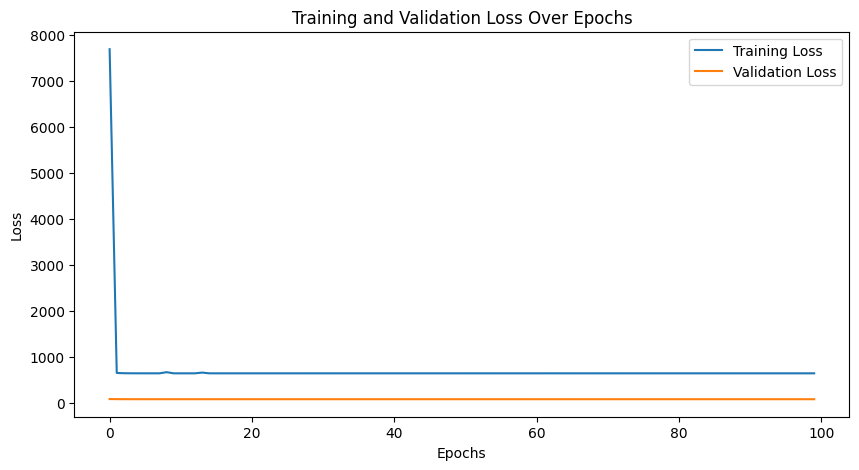

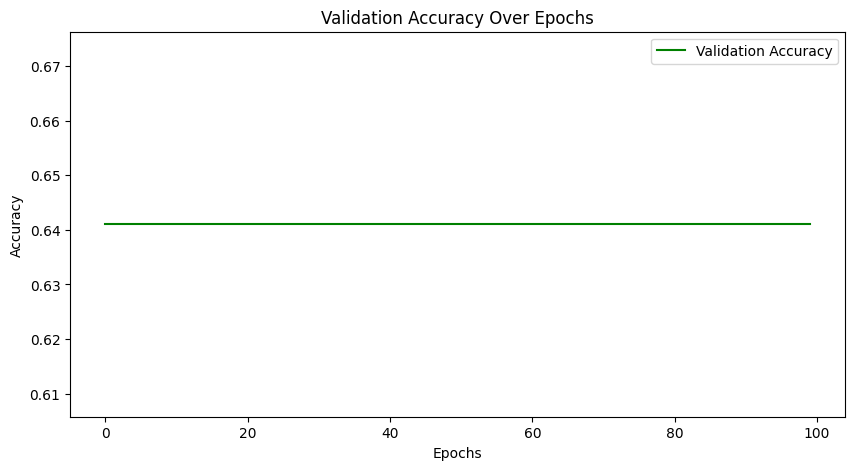

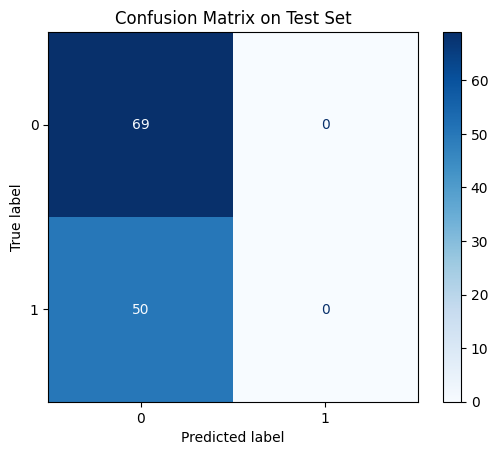


Running model with k = 80.0%
Epoch: 0, Training Loss: 13419.8825
Validation Loss: 80.8153, Validation Accuracy: 0.6410
Epoch: 1, Training Loss: 647.3547
Validation Loss: 78.9005, Validation Accuracy: 0.6410
Epoch: 2, Training Loss: 643.0247
Validation Loss: 78.1334, Validation Accuracy: 0.6410
Epoch: 3, Training Loss: 641.6156
Validation Loss: 77.7658, Validation Accuracy: 0.6410
Epoch: 4, Training Loss: 676.5594
Validation Loss: 77.6684, Validation Accuracy: 0.6410
Epoch: 5, Training Loss: 641.0951
Validation Loss: 77.4871, Validation Accuracy: 0.6410
Epoch: 6, Training Loss: 643.4654
Validation Loss: 77.5522, Validation Accuracy: 0.6410
Epoch: 7, Training Loss: 641.0059
Validation Loss: 77.4306, Validation Accuracy: 0.6410
Epoch: 8, Training Loss: 640.9386
Validation Loss: 77.3613, Validation Accuracy: 0.6410
Epoch: 9, Training Loss: 640.8582
Validation Loss: 77.2631, Validation Accuracy: 0.6410
Epoch: 10, Training Loss: 641.7765
Validation Loss: 77.2574, Validation Accuracy: 0.6410

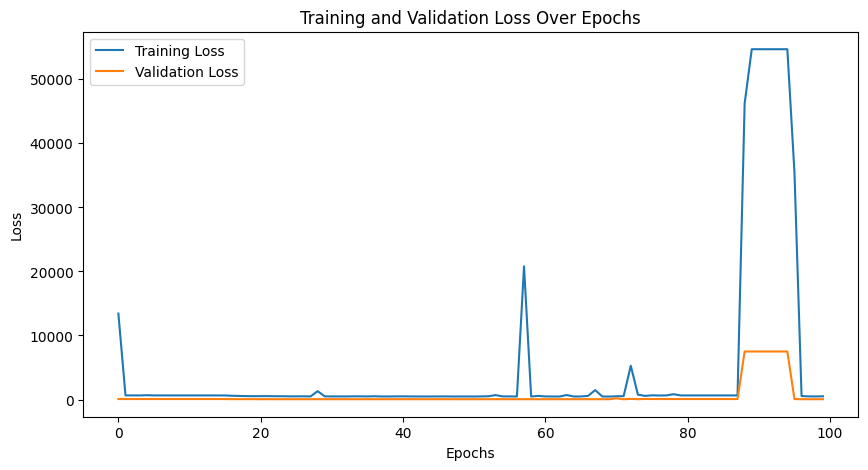

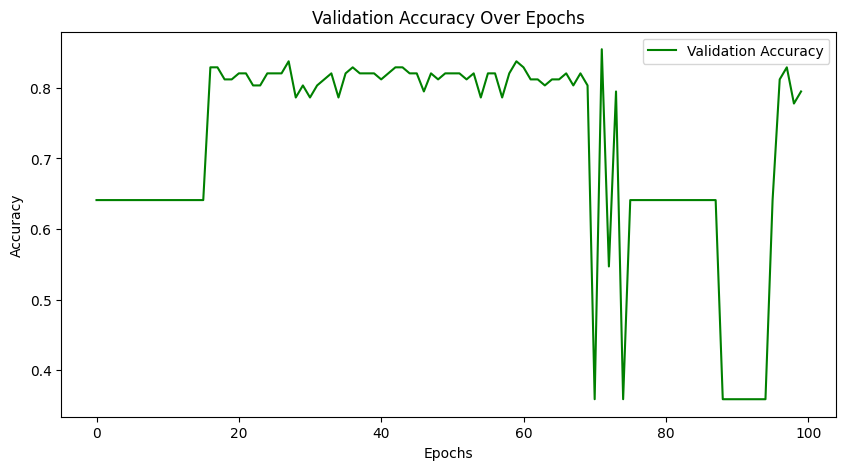

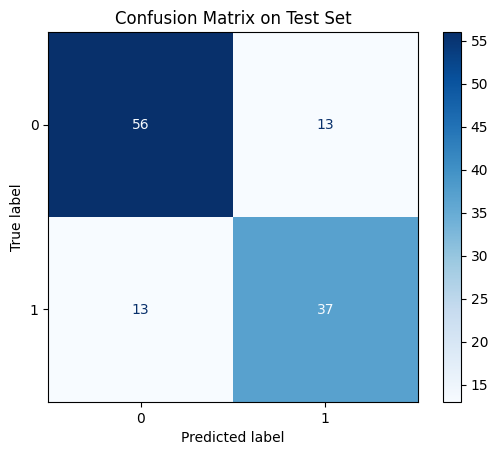


Running model with k = 60.0%
Epoch: 0, Training Loss: 3785.4358
Validation Loss: 78.7386, Validation Accuracy: 0.6410
Epoch: 1, Training Loss: 973.0318
Validation Loss: 78.2813, Validation Accuracy: 0.6410
Epoch: 2, Training Loss: 641.7604
Validation Loss: 77.5900, Validation Accuracy: 0.6410
Epoch: 3, Training Loss: 641.1113
Validation Loss: 77.4291, Validation Accuracy: 0.6410
Epoch: 4, Training Loss: 641.0806
Validation Loss: 77.3541, Validation Accuracy: 0.6410
Epoch: 5, Training Loss: 641.0703
Validation Loss: 77.2743, Validation Accuracy: 0.6410
Epoch: 6, Training Loss: 641.1431
Validation Loss: 77.2282, Validation Accuracy: 0.6410
Epoch: 7, Training Loss: 641.1002
Validation Loss: 77.4410, Validation Accuracy: 0.6410
Epoch: 8, Training Loss: 640.9565
Validation Loss: 77.2480, Validation Accuracy: 0.6410
Epoch: 9, Training Loss: 641.1475
Validation Loss: 77.3708, Validation Accuracy: 0.6410
Epoch: 10, Training Loss: 640.9164
Validation Loss: 77.1716, Validation Accuracy: 0.6410


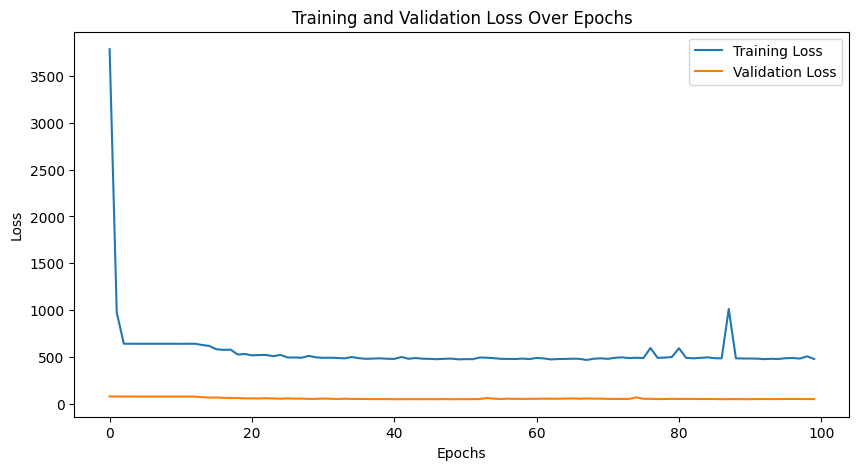

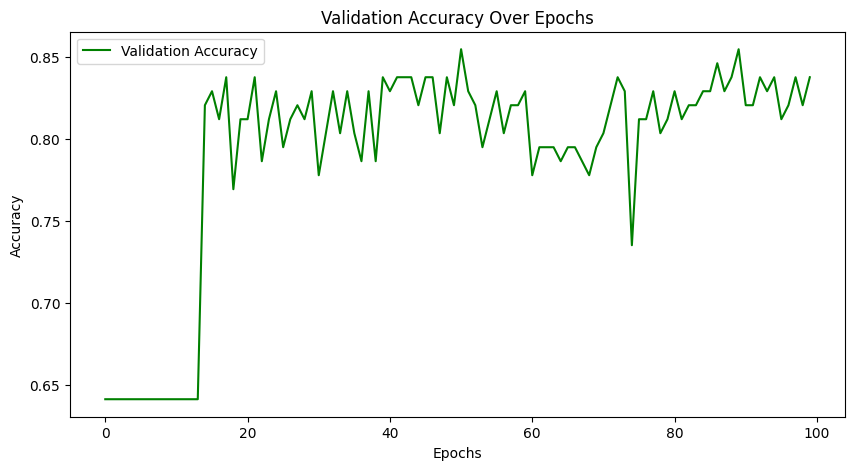

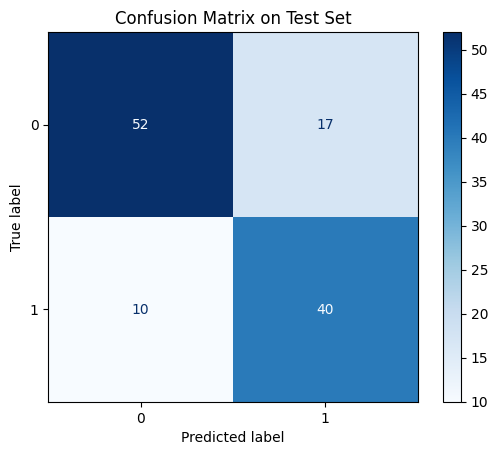

In [ ]:
# Run model for each k value
for k in k_values:
    print(f"\nRunning model with k = {k * 100}%")
    train_gnn_model(train_loader, val_loader,test_loader, k=k, m1=m1, m2=m2)